In [1]:
import sys

import numpy as np
import xarray as xr
import geopandas as gpd

from odc.geo.gridspec import GridSpec
from odc.geo.geobox import GeoBox
from odc.geo.geom import BoundingBox
from odc.geo.types import xy_

import datacube
dc = datacube.Datacube()

from dea_tools.datahandling import load_reproject

sys.path.insert(1, "/home/jovyan/code/supratidal_forests/functions")
from least_cost_path import xr_cost_distance, load_connectivity_mask_aquatic

### setup gridspec

In [2]:
# Expanded Extents 96 km tiling grid
gs_c3_expanded = GridSpec(
    crs="EPSG:3577",
    resolution=30,
    tile_shape=(3200, 3200),
    origin=xy_(-4416000, -6912000),
)

In [3]:
# Visualising whole grid
# Set bounding box
c3_bbox = BoundingBox(
    left=-2400000, bottom=-5088000, right=2784000, top=-864000, crs="EPSG:3577"
)

# Convert grid to geopandas polygon dataset covering full C3 grid extent
grid_gdf = gpd.GeoDataFrame.from_features(
    gs_c3_expanded.geojson(bbox=c3_bbox),
    crs="EPSG:4326", # TODO: Raf, why is this crs different to above c3_bbox? This seems problematic. Please investigate
)
grid_gdf.explore()

In [4]:
# Extract GeoBox for specific tile 
bbox = (45, 58) # x51y54
geobox = gs_c3_expanded[bbox]  
geobox.explore()

### load in layers to make connectivity mask
- DEA mangroves
- JCU saltmarsh
- CEM tidal Flats, Intertidal reefs and Intertidal rocky substratum (2), Mangroves (3), Saltmarsh (4), Intertidal Seagrass (5)

In [5]:
# Buffer input geobox and reduce resolution to ensure that the
# connectivity analysis is less affected by edge effects
buffer = 20000 # this is from load_connectivity_mask function. hardcoded here and will need to change if function value is change in load_connectivity_mask_aquatic
geobox_buffered = GeoBox.from_bbox(
    geobox.buffered(xbuff=buffer, ybuff=buffer).boundingbox,
    resolution=30,
    tight=True,
)

In [6]:
# Load srtm to buffered geobox
srtm_ds = dc.load(product = 'ga_srtm_dem1sv1_0', resampling="bilinear", like=geobox_buffered).squeeze()
srtm = srtm_ds.dem_h

# load in DEA mangroves
DEAmangrove = dc.load(product = 'ga_ls_mangrove_cover_cyear_3', time = ("2020", "2020"), like=geobox_buffered)
# if no mangroves within AOI, create dummy xr.dataarray
if DEAmangrove.data_vars == {}:
    mangrove = xr.DataArray(np.zeros_like(srtm), coords=srtm.coords, dims=srtm.dims, attrs=srtm.attrs)
else:
    # get output of mangrove == 1, not mangrove == 0
    mangrove = (DEAmangrove.canopy_cover_class != 255)

# Load in JCU saltmarsh
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltmarsh-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
# saltmarsh = rio_slurp_xarray(geotiff_path, gbox=srtm_buffered.geobox)
# saltmarsh.attrs['crs'] = 'EPSG:3577'
saltmarsh = load_reproject(path=geotiff_path, how=geobox_buffered)

# Load in JCU saltflat
geotiff_path = '/home/jovyan/gdata1/data/saltmarsh/JCU_Australia-saltflat-extent_v1-0.tif'
# load in geotiff again but with identical extent from srtm
# saltflat = rio_slurp_xarray(geotiff_path, gbox=srtm_buffered.geobox)
# saltflat.attrs['crs'] = 'EPSG:3577'
saltflat = load_reproject(path=geotiff_path, how=geobox_buffered)

# Load in CEM data
geotiff_path = '/home/jovyan/gdata1/projects/coastal/supratidal_forests/data/CEM_v002/ga_s2ls_coastalecosystems_cyear_3_2021--P1Y_interim_classification_0-0-2.tif'
CEM_data = load_reproject(path=geotiff_path, how=geobox_buffered)
CEM = ~CEM_data.isnull()

In [7]:
# ocean nodata points
srtm_da = srtm == srtm.nodata

# combine masks for LCP, where 1 indicates aquatic features to start calculating LCP from, 0 are areas that will be given a LCP value
aquatic = xr.where((mangrove == True) | (saltmarsh == True) | 
                   (saltflat == True) | (CEM == True) | (srtm_da == True), 1, 0).astype('bool').squeeze('time') # TODO: Raf, investigate issue sometimes here with time dim (i.e. tile 45, 57)
# load_reproject is dask arrays, change to dataarray
aquatic = aquatic.compute()

### run least cost path

In [8]:
# Run connectivity mask analysis
costdist_mask, costdist_da = load_connectivity_mask_aquatic(dc, geobox, starts_da = aquatic) # TODO: Raf, check buffer distance, default is 20km, but we might need more. Look at adjacent tiles across country to find an appropriate distance

### generate connectivity probability product

In [9]:
# mask on srtm valid values (i.e. mask out ocean from costdist_da)
# Access nodata value from the DataArray attributes
nodata_value = srtm.attrs.get("nodata", None)

# Replace nodata values with np.nan if nodata_value is defined
if nodata_value is not None:
    srtm_masked = srtm.where(srtm != nodata_value, np.nan)
else:
    print("No nodata value found in attributes.")
# Apply the mask and ensure NaNs are propagated form srtm_masked
costdist_da_masked = costdist_da.where(~np.isnan(srtm_masked))

In [10]:
min_value = 0
max_value = 3500 # TODO: Raf to reevaluate, currently adding the reasonable max value we found in field data across australia 

# Clip values above max_value
costdist_da_clip = xr.where(costdist_da_masked > max_value, np.nan, costdist_da_masked.values)

# Normalize the data to the range [0, 1] by subtracting the minimum and dividing by the range
costdist_da_norm = (costdist_da_clip - min_value) / (max_value - min_value)

# invert the normalisation to make connectivity layer output
costdist_da_norm_invert = (1 - costdist_da_norm)

PosixPath('supratidal_connectivity_model.tif')

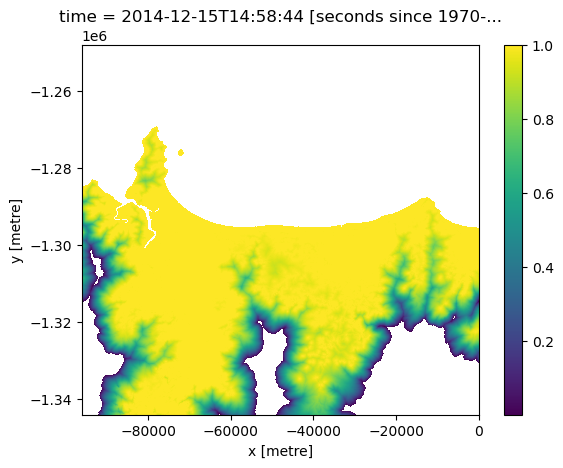

In [12]:
costdist_da_norm_invert.plot()
costdist_da_norm_invert.odc.write_cog("supratidal_connectivity_model.tif", overwrite=True)